# Efficient Synaptic Computation


@[Chaoming Wang](mailto:adaduo@outlook.com)

In a real project, the most of simulation time spends on the computation of the synapses. Therefore, figuring out what is the most efficient way to do synaptic computation is a necessary step to accelerate your computational project. Here, let's take an E/I balance network as an example to illustrate how to code an efficient synaptic computation.

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.__version__

'1.1.0'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

The E/I balance network COBA is adopted from (Vogels & Abbott, 2005) [1].

In [3]:
# Parameters for network structure
num = 4000
num_exc = int(num * 0.75)
num_inh = int(num * 0.25)

**Neuron Model**

In COBA network, each integrate-and-fire neuron is characterized by a time constant, $\tau$ = 20 ms, and a resting membrane potential, $V_{rest}$ = -60 mV. Whenever the membrane potential crosses a spiking threshold of -50 mV, an action potential is generated and the membrane potential is reset to the resting potential, where it remains clamped for a 5 ms refractory period. The membrane voltages are calculated as follows:

$$
\tau {dV \over dt} = (V_{rest} - V) + g_{exc}(E_{exc} - V) + g_{inh}(E_{inh} - V)
$$

where reversal potentials are $E_{exc} = 0$ mV and $E_{inh} = -80$ mV. 

In [4]:
# Parameters for the neuron
tau = 20  # ms
Vt = -50  # mV
Vr = -60  # mV
El = -60  # mV
ref_time = 5.0  # refractory time, ms
I = 20.

In [5]:
class LIF(bp.NeuGroup):
  def __init__(self, size, **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # variables
    self.V = bm.Variable(bm.zeros(size))
    self.input = bm.Variable(bm.zeros(size))
    self.spike = bm.Variable(bm.zeros(size, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, V, t, Iexc):
    dV = (Iexc + El - V) / tau
    return dV

  def update(self, _t, _dt):
    for i in range(self.num):
      self.spike[i] = 0.
      if (_t - self.t_last_spike[i]) > ref_time:
        V = self.integral(self.V[i], _t, self.input[i])
        if V >= Vt:
          self.V[i] = Vr
          self.spike[i] = 1.
          self.t_last_spike[i] = _t
        else:
          self.V[i] = V
      self.input[i] = I

**Synapse Model**

In COBA network, when a neuron fires, the appropriate synaptic variable of its postsynaptic targets are increased, $g_{exc} \gets g_{exc} + \Delta g_{exc}$ for an excitatory presynaptic neuron and $g_{inh} \gets g_{inh} + \Delta g_{inh}$ for an inhibitory presynaptic neuron. Otherwise, these parameters obey the following equations:

$$
\tau_{exc} {dg_{exc} \over dt} = -g_{exc} \quad (1) \\
\tau_{inh} {dg_{inh} \over dt} = -g_{inh} \quad (2)
$$

with synaptic time constants $\tau_{exc} = 5$ ms, $\tau_{inh} = 10$ ms, $\Delta g_{exc} = 0.6$ and $\Delta g_{inh} = 6.7$. 

In [6]:
# Parameters for the synapse
tau_exc = 5  # ms
tau_inh = 10  # ms
E_exc = 0.  # mV
E_inh = -80.  # mV
delta_exc = 0.6  # excitatory synaptic weight
delta_inh = 6.7  # inhibitory synaptic weight

In [7]:
def run_net(neu_model, syn_model):
  E = neu_model(num_exc, monitors=['spike'])
  E.V[:] = bm.random.randn(num_exc) * 5. + Vr
    
  I = neu_model(num_inh, monitors=['spike'])
  I.V[:] = bm.random.randn(num_inh) * 5. + Vr
  
  E2E = syn_model(pre=E, post=E, conn=bp.connect.FixedProb(0.02),
                  tau=tau_exc, weight=delta_exc, E=E_exc)
  E2I = syn_model(pre=E, post=I, conn=bp.connect.FixedProb(0.02),
                  tau=tau_exc, weight=delta_exc, E=E_exc)
  I2E = syn_model(pre=I, post=E, conn=bp.connect.FixedProb(0.02),
                  tau=tau_inh, weight=delta_inh, E=E_inh)
  I2I = syn_model(pre=I, post=I, conn=bp.connect.FixedProb(0.02),
                  tau=tau_inh, weight=delta_inh, E=E_inh)

  net = bp.Network(E, I, E2E, E2I, I2E, I2I)
  net = bm.jit(net)
  t = net.run(100., report=0.1)

  fig, gs = bp.visualize.get_figure(row_num=5, col_num=1, row_len=1, col_len=10)
  fig.add_subplot(gs[:4, 0])
  bp.visualize.raster_plot(E.mon.ts, E.mon.spike, xlim=(0, 100.), ylabel='E Group', xlabel='')
  fig.add_subplot(gs[4, 0])
  bp.visualize.raster_plot(I.mon.ts, I.mon.spike, xlim=(0, 100.), ylabel='I Group', show=True)

  return t

## Matrix-based connection

The matrix-based synaptic connection is one of the most intuitive way to build synaptic computations. The connection matrix between two neuron groups can be easily obtained through the function of `connector.requires('conn_mat')` (details please see [Synaptic Connectivity](synaptic_connectivity.ipynb)). Each connection matrix is an array with the shape of `(num_pre, num_post)`, like 

<img src="../_static/syn-example-conn_mat.png" width="400 px" align="left">

Based on `conn_mat`, the updating logic of the above synapses can be coded as:

In [8]:
class SynMat1(bp.TwoEndConn):

  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynMat1, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # p1: connections
    self.conn = conn(pre.size, post.size)
    self.conn_mat = self.conn.requires('conn_mat')

    # variables
    self.g = bm.Variable(bm.zeros(self.conn_mat.shape))
    
    # function
    self.integral = bp.odeint(self.derivative)
  
  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    spike_on_syn = bm.expand_dims(self.pre.spike, 1) * self.conn_mat # p2
    self.g[:] += spike_on_syn * self.weight # p3
    self.post.input[:] += bm.sum(self.g, axis=0) * (self.E - self.post.V) # p4

In the above defined `SynMat1` class, at "p1" line we requires a "conn_mat" structure for the later synaptic computation; at "p2" we get spikes for each synaptic connections according to "conn_mat" and "presynaptic spikes"; then at "p3", the spike-triggered synaptic variables are added onto its postsynaptic targets; at final "p4" code line, all connected synaptic values are summed to get the current effective conductance by *np.sum(self.g, axis=0)*. 

Now, let's inspect the performance of this matrix-based synapse. 

Compilation used 9.2165 s.
Start running ...
Run 10.0% used 12.198 s.
Run 20.0% used 24.505 s.
Run 30.0% used 36.314 s.
Run 40.0% used 48.276 s.
Run 50.0% used 60.023 s.
Run 60.0% used 71.953 s.
Run 70.0% used 84.186 s.
Run 80.0% used 96.172 s.
Run 90.0% used 108.644 s.
Run 100.0% used 121.879 s.
Simulation is done in 121.879 s.



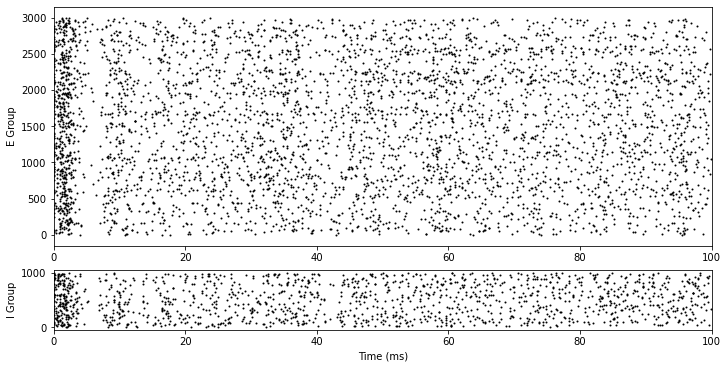

In [9]:
t_syn_mat1 = run_net(neu_model=LIF, syn_model=SynMat1)

This matrix-based synapse structure is very inefficient, because 99.9% time were wasted on the synaptic computation. We can inspect this by only running the neuron group models. 

In [10]:
group = bm.jit(LIF(num, monitors=['spike']))
group.V[:] = bm.random.randn(num) * 5. + Vr

group.run(100., inputs=('input', 5.), report=True)

Compilation used 0.1631 s.
Start running ...
Run 100.0% used 0.026 s.
Simulation is done in 0.026 s.



0.02644968032836914

As you can see, the neuron group only spends 0.026 s to run. After normalized by the total running time 212.941 s, the neuron group running only accounts for about 0.0122 percent. 

### Event-based updating

The inefficiency in the above matrix-based computation comes from the horrendous waste of time on synaptic computation. First, it is uncommon for a neuron to generate a spike; Second, in a group of neuron, the generated spikes (`self.pre.spike`) are usually sparse. Therefore, at many time points, there are many zeros in `self.pre.spike`, which results `self.g` add many unnecessary zeros (`self.g += spike_on_syn * self.weight`). 

Alternatively, we can update `self.g` only when the pre-synaptic neuron produces a spike event (this is called as the **event-based updating** method):

In [11]:
class SynMat2(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynMat2, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.conn_mat = self.conn.requires('conn_mat')

    # variables
    self.g = bm.Variable(bm.zeros(self.conn_mat.shape))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1
    for pre_i, spike in enumerate(self.pre.spike):
      if spike:
        self.g[pre_i] += self.conn_mat[pre_i] * self.weight
    self.post.input[:] += bm.sum(self.g, axis=0) * (self.E - self.post.V)

Compared to `SynMat1`, we replace "p2" and "p3" in `SynMat1` with "p1" in `SynMat2`. Now, the updating logic is only when the pre-synaptic neuron emits a spike (`if spike`), the connected post-synaptic state `g` will be updated (`self.g[pre_i] += self.conn_mat[pre_i] * self.weight`).

Compilation used 8.2470 s.
Start running ...
Run 10.0% used 5.836 s.
Run 20.0% used 11.851 s.
Run 30.0% used 17.728 s.
Run 40.0% used 23.709 s.
Run 50.0% used 29.537 s.
Run 60.0% used 35.502 s.
Run 70.0% used 41.399 s.
Run 80.0% used 47.329 s.
Run 90.0% used 53.282 s.
Run 100.0% used 59.405 s.
Simulation is done in 59.405 s.



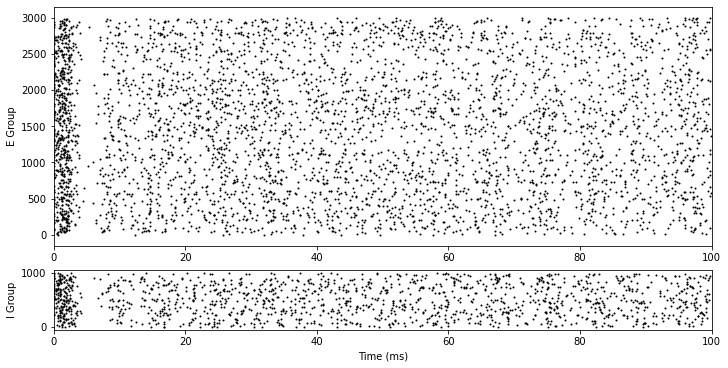

In [12]:
t_syn_mat2 = run_net(neu_model=LIF, syn_model=SynMat2)

Such event-based matrix connection boosts the running speed nearly 2 times, but it's not good enough.

## Vector-based connection

Matrix-based synaptic computation may be straightforward, but can cause severe wasted RAM memory and inefficient computation. Imaging you want to connect 10,000 pre-synaptic neurons to 10,000 post-synaptic neurons with a 10% random connection probability. Using *matrix*, you need $10^8$ floats to save the synaptic state, and at each update step, you need do computation on $10^8$ floats. Actually, the number of values you really needed is only $10^7$. See, there is a huge memory waste and computing resource inefficiency. 

### `pre_ids` and `post_ids`

An effective method to solve this problem is to use *vector* to store the connectivity between neuron groups and the corresponding synaptic states. For the above defined connectivity `conn_mat`, we can align the connected pre-synaptic neurons and the post-synaptic neurons by two one-dimensional arrays: *pre_ids* and *post_ids*,

<img src="../_static/syn-example-pre_ids-post_ids.png" width="700 px" align="left">

In such a way, we only need two vectors (`pre_ids` and `post_ids`, each has $10^7$ floats) to store the synaptic connectivity. And, at each time step, we just need update a synaptic state vector with $10^7$ floats. 

In [13]:
class SynVec1(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec1, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = self.conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.g = bm.Variable(bm.zeros(self.num))
    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    for syn_i in range(self.num):
      # p1: update
      pre_i = self.pre_ids[syn_i]
      if self.pre.spike[pre_i]:
        self.g[syn_i] += self.weight
      # p2: output
      post_i = self.post_ids[syn_i]
      self.post.input[post_i] += self.g[syn_i] * (self.E - self.post.V[post_i])

In `SynVec1` class, we first update the synaptic state with "p1" code block, in which the synaptic state `self.g[syn_i]` is updated when the pre-synaptic neuron generates a spike (`if self.pre.spike[pre_i]`); then, at "p2" code block, we output the synaptic states onto the post-synaptic neurons. 

Compilation used 2.9950 s.
Start running ...
Run 10.0% used 0.119 s.
Run 20.0% used 0.246 s.
Run 30.0% used 0.368 s.
Run 40.0% used 0.481 s.
Run 50.0% used 0.602 s.
Run 60.0% used 0.724 s.
Run 70.0% used 0.833 s.
Run 80.0% used 0.944 s.
Run 90.0% used 1.057 s.
Run 100.0% used 1.168 s.
Simulation is done in 1.168 s.



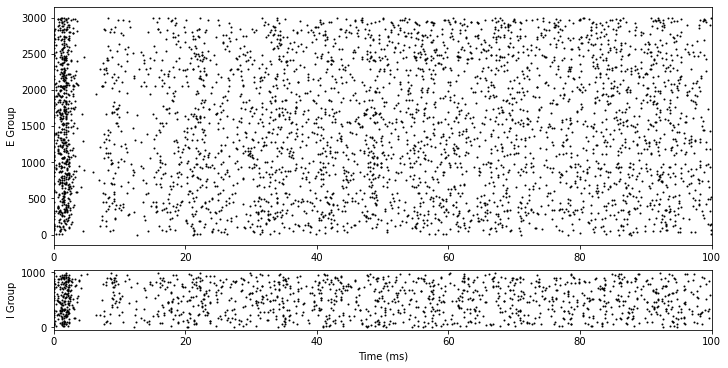

In [14]:
t_syn_vec1 = run_net(neu_model=LIF, syn_model=SynVec1)

Great! Transform the matrix-based connection into the vector-based connection makes us get a huge speed boost. However, there also exists redundant part in `SynVec1` class. This is because a pre-synaptic neuron may connect to many post-synaptic neurons and thus at each step updating we will judge a pre-synaptic neuron whether generates a spike many times (`self.pre.spike[pre_i]`).

### `pre2syn` and `post2syn`

In order to solve the above problem, here we create another two synaptic structures `pre2syn` and `post2syn` to help us retrieve the synapse states which connected with the pre-synaptic neuron $i$ and the post-synaptic neuron $j$. 

In a `pre2syn` list, each `pre2syn[i]` stores the synaptic state indexes projected from the pre-synaptic neuron $i$.  

<img src="../_static/syn-example-pre2syn.png" width="200 px" align="left">

Similarly, we can create a `post2syn` list to indicate the connections between synapses and post-synaptic neurons. For each post-synaptic neuron $j$, `post2syn[j]` stores the indexes of synaptic elements which connected to the post neuron $j$. 

<img src="../_static/syn-example-post2syn.png" width="200 px" align="left">

Based on these connectivity mappings, we can define another version of synapse model by using `pre2syn` and `post2syn`:

In [15]:
class SynVec2(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec2, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.pre2syn, self.post2syn = self.conn.requires('pre_ids', 'pre2syn', 'post2syn')
    self.num = len(self.pre_ids)

    # variables
    self.g = bm.Variable(bm.zeros(self.num))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1: update
    for pre_i in range(self.pre.num):
      if self.pre.spike[pre_i]:
        for syn_i in self.pre2syn[pre_i]:
          self.g[syn_i] += self.weight
    # p2: output
    for post_i in range(self.post.num):
      for syn_i in self.post2syn[post_i]:
        self.post.input[post_i] += self.g[syn_i] * (self.E - self.post.V[post_i])

In this `SynVec2` class, at "p1" code-block, we update synaptic states by the for-loop with the size of pre-synaptic number. If the pre-synaptic neuron elicits a spike `self.pre.spike[pre_i]`, we will for-loop its connected synaptic states by `for syn_i in self.pre2syn[pre_i]`. In such a way, we only need to judge the pre-synaptic neuron `pre_i` spike state once. Similarly, at "p2" code-block, the synaptic output is also implemented with the post-synaptic neuron for-loop.

Compilation used 3.2681 s.
Start running ...
Run 10.0% used 0.124 s.
Run 20.0% used 0.247 s.
Run 30.0% used 0.375 s.
Run 40.0% used 0.500 s.
Run 50.0% used 0.630 s.
Run 60.0% used 0.777 s.
Run 70.0% used 0.926 s.
Run 80.0% used 1.058 s.
Run 90.0% used 1.188 s.
Run 100.0% used 1.315 s.
Simulation is done in 1.315 s.



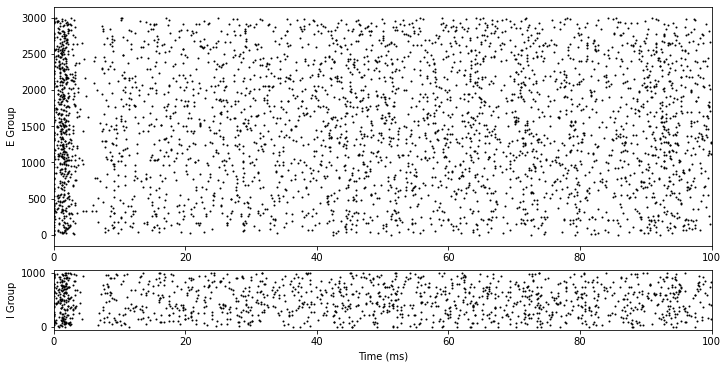

In [16]:
t_syn_vec2 = run_net(neu_model=LIF, syn_model=SynVec2)

We only got a small increase in speed performance. This is because the optimization of the "update" block has run its course. Currently, the most of the running costs spend on the "output" block.

### `pre2post` and `post2pre`

Notice that for this kind of synapse model, the synaptic states $g$ onto a post-synaptic neuron can be modeled together. This is because the synaptic state evolution according to the differential equation (1) and (2) after the pre-synaptic spikes can be superposed. This means that we can declare a synaptic state `self.g` with the shape of `post.num`, not the shape of the synapse number.

In order to achieve this goal, we create another two synaptic structures (`pre2post` and `post2pre`) which establish the direct mapping between the pre-synaptic neurons and the post-synaptic neurons can be established. `pre2post` contains the connected post-synaptic neurons indexes, in which `pre2post[i]` retrieves the post neuron ids projected from pre-synaptic neuron $i$. `post2pre` contains the pre-synaptic neurons indexes, in which `post2pre[j]` retrieves the pre-syanptic neuron ids which project to post-synaptic neuron $j$. 

Also, 

<img src="../_static/syn-example-pre2post.png" width="200 px" align="left">

<img src="../_static/syn-example-post2pre.png" width="200 px" align="left">

In [17]:
class SynVec3(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec3, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre2post = self.conn.requires('pre2post')

    # variables
    self.g = bm.Variable(bm.zeros(post.num))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1: update
    for pre_i in range(self.pre.num):
      if self.pre.spike[pre_i]:
        for post_i in self.pre2post[pre_i]:
          self.g[post_i] += self.weight
    # p2: output
    self.post.input[:] += self.g * (self.E - self.post.V)

In `SynVec3` class, we require a `pre2post` structure, and then at "p1" code-block, when the pre-synaptic neuron `pre_i` emits a spike, the connected post-synaptic neurons' state `self.g[post_i]` will increase the conductance. 

Compilation used 4.1475 s.
Start running ...
Run 10.0% used 0.009 s.
Run 20.0% used 0.016 s.
Run 30.0% used 0.024 s.
Run 40.0% used 0.032 s.
Run 50.0% used 0.039 s.
Run 60.0% used 0.046 s.
Run 70.0% used 0.053 s.
Run 80.0% used 0.060 s.
Run 90.0% used 0.067 s.
Run 100.0% used 0.075 s.
Simulation is done in 0.076 s.



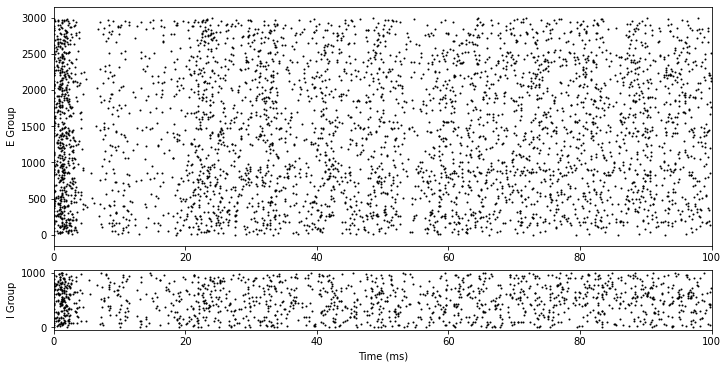

In [18]:
t_syn_vec3 = run_net(neu_model=LIF, syn_model=SynVec3)

Yeah, the running speed gets a huge boosting, which demonstrates the super effectiveness of this kind of synaptic computation.

### `pre_slice` and `post_slice`

However, it is not perfect. This is because `pre2syn`, `post2syn`, `pre2post` and `post2pre` are all the data with the `list` type, which can not be directly deployed to GPU devices. What the GPU device prefers are only arrays.

To solve this problem, we, instead, can create a `post_slice` connection structure which stores the *start* and the *end* position on the synpase state for each connected post-synaptic neuron $j$. `post_slice` can be implemented by aligning the pre ids according to the sequential post id $0, 1, 2, ...$ (look the following illustrating figure). For each post neuron $j$, `start, end = post_slice[j]` retrieves the start/end position of the connected synapse states.

<img src="../_static/syn-example-post_slice_syn.png" width="700 px" align="left">

Therefore, an alternative updating logic of `pre2syn` and `post2syn` (in `SynVec2` class) can be replaced by `post_slice` and `pre_ids`:

In [19]:
class SynVec4(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec4, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_slice = self.conn.requires('pre_ids', 'post_slice')
    self.num = len(self.pre_ids)

    # variables
    self.g = bm.Variable(bm.zeros(self.num))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1: update
    for syn_i in range(self.num):
      pre_i = self.pre_ids[syn_i]
      if self.pre.spike[pre_i]:
        self.g[syn_i] += self.weight
    # p2: output
    for post_i in range(self.post.num):
      start, end = self.post_slice[post_i]
      # for syn_i in range(start, end):
      self.post.input[post_i] += self.g[start: end].sum() * (self.E - self.post.V[post_i])

Compilation used 3.3875 s.
Start running ...
Run 10.0% used 0.109 s.
Run 20.0% used 0.215 s.
Run 30.0% used 0.317 s.
Run 40.0% used 0.422 s.
Run 50.0% used 0.526 s.
Run 60.0% used 0.636 s.
Run 70.0% used 0.740 s.
Run 80.0% used 0.841 s.
Run 90.0% used 0.943 s.
Run 100.0% used 1.041 s.
Simulation is done in 1.041 s.



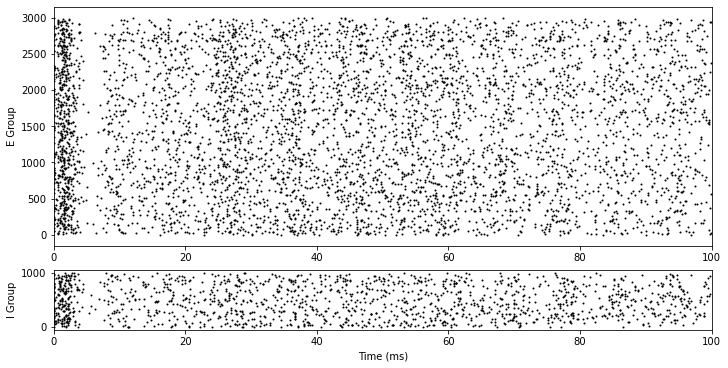

In [20]:
t_syn_vec4 = run_net(neu_model=LIF, syn_model=SynVec4)

Similarly, a connection mapping `pre_slice` can also be implemented, in which for each pre-synaptic neuron $i$, `start, end = pre_slice[i]` retrieves the start/end position of the connected synapse states.

<img src="../_static/syn-example-pre_slice_syn.png" width="700 px" align="left">

Moreover, an alternative updating logic of `pre2post` (in `SynVec3` class) can also be replaced by `pre_slice` and `post_ids`: 

In [21]:
class SynVec5(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec5, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_slice, self.post_ids = self.conn.requires('pre_slice', 'post_ids')

    # variables
    self.g = bm.Variable(bm.zeros(post.num))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1: update
    for pre_i in range(self.pre.num):
      if self.pre.spike[pre_i]:
        start, end = self.pre_slice[pre_i]
        for post_i in self.post_ids[start: end]:
          self.g[post_i] += self.weight
    # p2: output
    self.post.input[:] += self.g * (self.E - self.post.V)

Compilation used 4.2521 s.
Start running ...
Run 10.0% used 0.007 s.
Run 20.0% used 0.014 s.
Run 30.0% used 0.022 s.
Run 40.0% used 0.030 s.
Run 50.0% used 0.036 s.
Run 60.0% used 0.041 s.
Run 70.0% used 0.049 s.
Run 80.0% used 0.055 s.
Run 90.0% used 0.062 s.
Run 100.0% used 0.068 s.
Simulation is done in 0.068 s.



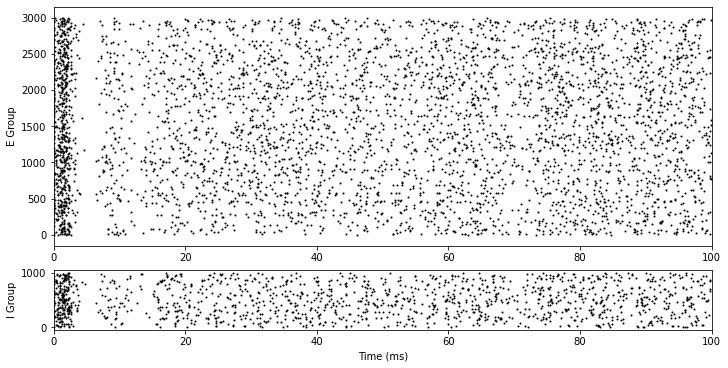

In [22]:
t_syn_vec5 = run_net(neu_model=LIF, syn_model=SynVec5)

## Speed comparison

In this tutorial, we introduce nine different synaptic connection structures: 

1. **conn_mat** : The connection matrix with the shape of `(pre_num, post_num)`.
2. **pre_ids**: The connected pre-synaptic neuron indexes, a vector with the shape pf `syn_num`.
3. **post_ids**: The connected post-synaptic neuron indexes, a vector with the shape pf `syn_num`.
4. **pre2syn**: A list (with the length of `pre_num`) contains the synaptic indexes connected by each pre-synaptic neuron. `pre2syn[i]` denotes the synapse ids connected by the pre-synaptic neuron $i$.
5. **post2syn**: A list (with the length of `post_num`) contains the synaptic indexes connected by each post-synaptic neuron. `post2syn[j]` denotes the synapse ids connected by the post-synaptic neuron $j$.
6. **pre2post**: A list (with the length of `pre_num`) contains the post-synaptic indexes connected by each pre-synaptic neuron. `pre2post[i]` retrieves the post neurons connected by the pre neuron $i$.
7. **post2pre**: A list (with the length of `post_num`) contains the pre-synaptic indexes connected by each post-synaptic neuron. `post2pre[j]` retrieves the pre neurons connected by the post neuron $j$.
8. **pre_slice**: A two dimensional matrix with the shape of `(pre_num, 2)` stores the *start* and *end* positions on the synapse state for each connected pre-synaptic neuron $i$ .
9. **post_slice**: A two dimensional matrix with the shape of `(post_num, 2)` stores the *start* and *end* positions on the synapse state for each connected post-synaptic neuron $j$ .

We illustrate their efficiency by a spare randomly connected E/I balance network COBA [1]. We summarize their speed in the following comparison figure:

In [23]:
names = ['mat 1', 'mat 2', 'vec 1', 'vec 2', 'vec 3', 'vec 4', 'vec 5']
times = [t_syn_mat1, t_syn_mat2, t_syn_vec1, t_syn_vec2, t_syn_vec3, t_syn_vec4, t_syn_vec5]
xs = list(range(len(times)))

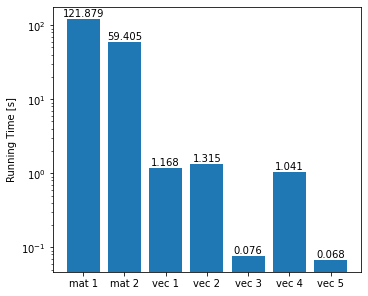

In [24]:

def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 0.5),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


fig, gs = bp.visualize.get_figure(1, 1, 4, 5)

ax = fig.add_subplot(gs[0, 0])
rects = ax.bar(xs, times)
ax.set_xticks(xs)
ax.set_xticklabels(names)
ax.set_yscale('log')
plt.ylabel('Running Time [s]')
autolabel(rects)

However, the speed comparison presented here does not mean that the vector-based connection is always better than the matrix-based connection. Vector-based synaptic model is well suitable to run on the JIT compilers like Numba. Whereas the matrix-based synaptic model is best to run on the array- or tensor-oriented backend such like NumPy, PyTorch, TensorFlow, and is highly suitable to solve problems for dense connections, such like all-to-all connection.

---

**References**:

[1] Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95
